# Amazon Fine Food Reviews Analysis
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

 Number of reviews: 568,454                                                                                                     
 Number of users: 256,059                                                                                                       
 Number of products: 74,258                                                                                                                                                                                                             
 Number of Attributes/Columns in data: 10
 
 Attributes:
1. IdRow Id
2. ProductIdUnique identifier for the product
3. UserIdUnqiue identifier for the user
4. ProfileNameProfile name of the user
5. HelpfulnessNumeratorNumber of users who found the review helpful
6. HelpfulnessDenominatorNumber of users who indicated whether they found the review helpful
7. ScoreRating between 1 and 5
8. TimeTimestamp for the review
9. SummaryBrief summary of the review
10. TextText of the review

In [0]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
import gensim
import pickle

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!ls 'gdrive/My Drive'

 AAIC-Win-V1.1.zip   Loka_Pavan_CV.docx
 Classroom	     Nikhil.pdf
'Colab Notebooks'    Reviews.csv
 database.sqlite     TR_OfferLetter.pdf
 FilteredData_250K   Video_20150103031442_by_videoshow.mp4
'final 10.psd'	    'WhatsApp Chat with Kavya aka )1.txt.pdf'


In [0]:
data = pd.read_csv("gdrive/My Drive/Reviews.csv")

In [0]:
# Data Cleaning :Duplication

sort_data = data.sort_values('ProductId',axis =0,ascending=True)

filtered_data = sort_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

final = filtered_data[filtered_data.HelpfulnessNumerator<=filtered_data.HelpfulnessDenominator]

In [8]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score greater than 3 to be positive and vice-versa
actualScore = final['Score']
positiveNegative = actualScore.map(partition) 
final['Score'] = positiveNegative

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


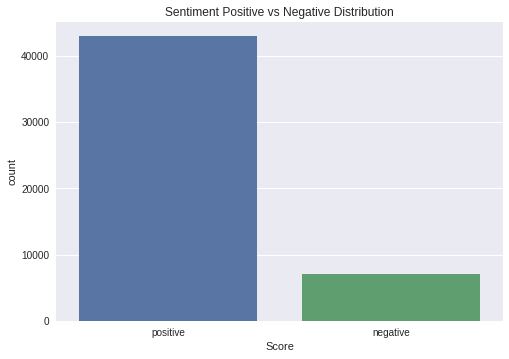

In [9]:
filtered_data_final = final.head(50000)
ax = plt.axes()
sns.countplot(filtered_data_final.Score,ax=ax)
ax.set_title('Sentiment Positive vs Negative Distribution')
plt.show()

In [0]:
# Data Cleaning :Duplication

sort_data = filtered_data_final.sort_values('ProductId',axis =0,ascending=True)

final = sort_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,positive,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150525,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...


In [0]:
reviews = final.Text.values
labels = np.array([1 if s=="positive" else 0 for s in final.Score.values])

In [0]:
#removing the punctuations from reviews

from string import punctuation
reviews_cleaned = []
for i in range(len(reviews)):
    reviews_cleaned.append(''.join([c.lower() for c in reviews[i] if c not in punctuation]))

In [14]:
#creating a corpus of words in our reviews

vocabulary = set(' '.join(reviews_cleaned).split())
print("Vocabulary size: ", len(vocabulary))

Vocabulary size:  70131


In [0]:
#calculating the frequency of each word in the reviews
from collections import Counter
tot_count = Counter()

for i in range(len(reviews)):
   for word in reviews[i].split():
        tot_count[word]+=1

In [0]:
total_count = tot_count.most_common()

In [0]:
#picking up the top 5000 frequent words
vocab_freq = []
count = 1
for word in total_count:
    vocab_freq.append(word[0])
    count = count+1
    if count == 20000:
      break

In [0]:
reviews_cleaned = []
    
for review in reviews:
    review_temp = [word for word in review.split() if word in vocab_freq]
    reviews_cleaned.append(' '.join(review_temp))

In [19]:
len(reviews_cleaned)

50000

In [0]:
# Store all the text from each review in a text variable
text = ' '.join(reviews_cleaned)

# List all the vocabulary contained in the reviews
vocabulary = set(text.split(' '))

# Map each word to an integer
vocabulary_to_int = {word:i for i,word in enumerate(vocabulary,0)}

In [0]:
#converting each word into a unique number
reviews_to_int = []
for i in range(len(reviews)):
    to_int = [vocabulary_to_int[word] for word in reviews_cleaned[i].split()]
    reviews_to_int.append(to_int)

In [22]:
review_lengths = [len(review) for review in reviews_to_int]
print("Shortest review:", min(review_lengths))
print("Longest revies:",max(review_lengths))

Shortest review: 1
Longest revies: 1699


In [0]:
from keras.preprocessing import sequence
# truncate and/or pad input sequences
max_review_length = 500
X = sequence.pad_sequences(reviews_to_int, maxlen=max_review_length)

In [0]:
from sklearn import model_selection
# split the data set into train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, labels, test_size=0.3, random_state=0)

In [25]:
print(X_train.shape)
print(X_train[1])

(35000, 500)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(20000,embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 656,651
Trainable params: 656,651
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
history = model.fit(X_train, y_train,
          batch_size= 1000,
          epochs= 10,
          verbose=1,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 148s 4ms/step - loss: 0.5197 - acc: 0.8471 - val_loss: 0.4053 - val_acc: 0.8597
Epoch 2/10
35000/35000 [==============================] - 145s 4ms/step - loss: 0.3861 - acc: 0.8590 - val_loss: 0.3692 - val_acc: 0.8597
Epoch 3/10
35000/35000 [==============================] - 145s 4ms/step - loss: 0.3108 - acc: 0.8657 - val_loss: 0.2775 - val_acc: 0.8819
Epoch 4/10
35000/35000 [==============================] - 145s 4ms/step - loss: 0.2219 - acc: 0.9088 - val_loss: 0.2633 - val_acc: 0.8904
Epoch 5/10
35000/35000 [==============================] - 145s 4ms/step - loss: 0.1752 - acc: 0.9312 - val_loss: 0.2686 - val_acc: 0.8942
Epoch 6/10
35000/35000 [==============================] - 146s 4ms/step - loss: 0.1393 - acc: 0.9472 - val_loss: 0.2788 - val_acc: 0.8880
Epoch 7/10
35000/35000 [==============================] - 147s 4ms/step - 

In [28]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3969071713050206
Test accuracy: 0.8837333333015442


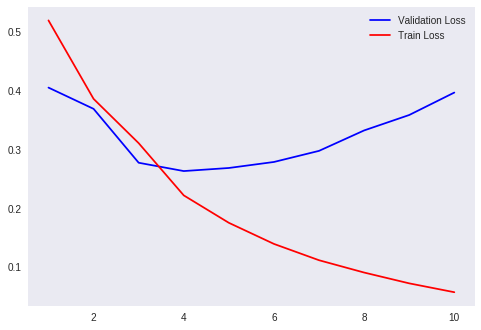

In [29]:
import matplotlib.pyplot as plt

x = list(range(1,11))
vy = history.history['val_loss']
ty = history.history['loss']
plt.plot(x, vy, 'b', label="Validation Loss")
plt.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
plt.show()

In [32]:
from keras.layers import Dropout
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(20000,embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(32,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           640000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 32)           8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 656,673
Trainable params: 656,673
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
history = model.fit(X_train, y_train,
          batch_size= 1000,
          epochs= 10,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 193s 6ms/step - loss: 0.5175 - acc: 0.8483 - val_loss: 0.4036 - val_acc: 0.8597
Epoch 2/10
35000/35000 [==============================] - 191s 5ms/step - loss: 0.3967 - acc: 0.8590 - val_loss: 0.3841 - val_acc: 0.8597
Epoch 3/10
35000/35000 [==============================] - 192s 5ms/step - loss: 0.3163 - acc: 0.8712 - val_loss: 0.2870 - val_acc: 0.8851
Epoch 4/10
35000/35000 [==============================] - 190s 5ms/step - loss: 0.2139 - acc: 0.9134 - val_loss: 0.2695 - val_acc: 0.8900
Epoch 5/10
35000/35000 [==============================] - 191s 5ms/step - loss: 0.1602 - acc: 0.9376 - val_loss: 0.2729 - val_acc: 0.8907
Epoch 6/10
35000/35000 [==============================] - 190s 5ms/step - loss: 0.1254 - acc: 0.9545 - val_loss: 0.3078 - val_acc: 0.8904
Epoch 7/10
35000/35000 [==============================] - 190s 5ms/step - loss: 0.0979 - acc: 0.9673 - val_loss: 0.3617 - 

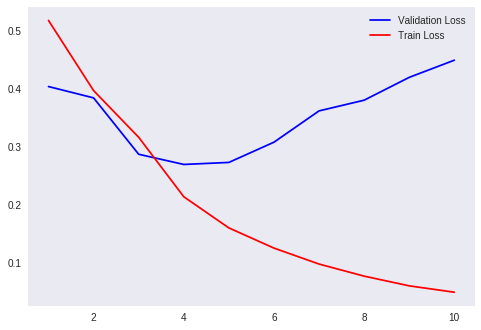

In [34]:
x = list(range(1,11))
vy = history.history['val_loss']
ty = history.history['loss']
plt.plot(x, vy, 'b', label="Validation Loss")
plt.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
plt.show()

In [0]:
from prettytable import PrettyTable
plot = PrettyTable()

plot.field_names = ["LSTM layers", "DropOuts","Train Accuracy","Test accuracy"]

In [0]:
plot.add_row(["1", "No",0.9828,0.883733])
plot.add_row(["2", "Yes",0.9866 ,0.87986])

In [37]:
print(plot)

+-------------+----------+----------------+---------------+
| LSTM layers | DropOuts | Train Accuracy | Test accuracy |
+-------------+----------+----------------+---------------+
|      1      |    No    |     0.9828     |    0.883733   |
|      2      |   Yes    |     0.9866     |    0.87986    |
+-------------+----------+----------------+---------------+
